## Radar map: comparing players characteristics

In the current code we will compare the attributes of two selected players in a radar type chart.

In [1]:
#!pip install statsbombpy
#!pip install mplsoccer
#!pip install soccerplots


from statsbombpy import sb
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from highlight_text import fig_text
import matplotlib as mpl
from mplsoccer.pitch import Pitch
from soccerplots.radar_chart import Radar

#Set general use colors
text_color = 'w'

Load data from Statsbomb and select information of interest

In [2]:
#Load data from Statsbomb API and select  information


PRO1 = pd.DataFrame() #Create dataset for later on gather all womens matches data
PRO2 = pd.DataFrame() #Create dataset for later on gather all womens matches data



#Select data from women's football competitions
df = sb.competitions()
df = df.loc[df['competition_gender'] == "female"].reset_index()




###Seleccionar datos a poner en el grafico
par=["player","goals_scored","xgs","xGShot","xG90","fault_part","suc_passes","Short_failed_passes","Long_failed_passes","PAdj_Tackle","PAdj_Tackle_part","Tackles_Won_Perc","PAdj_Int_part","TackDrib_Past_Perc","Clea_Part","drib_suc_perc","aerial_won_part"]


readytoplot = pd.DataFrame(columns=par)

credentials were not supplied. open data access only


Choose players we want to compare. We need to select the competition, season as well as the team where the player was enrolled.

In [3]:
#Seleccionar jugador1

competition1="FA Women's Super League"
season1="2018/2019"
team1="Chelsea FCW"
player1="Magdalena Ericsson"


#Seleccionar jugador2

competition2="FA Women's Super League"
season2="2018/2019"
team2="Chelsea FCW"
player2="Millie Bright"


player=[player1,player2]
season=[season1,season2]
team=[team1,team2]
competition=[competition1,competition2]


Retrieve information from all the matches these players participated in. And then calculate the possession held by the team and minutes played by the player of interest

In [4]:
%%capture
#Loop over every women's match and extract information
#wo_comp = women's football competition
#ma_sea = women's football match from certain competition
#wo_ma = women's football match

for i in range(len(player)):

    for z in range(len(df)):
        wom_comp = df.iloc[[z]]
        ma_sea = sb.matches(competition_id=wom_comp['competition_id'].values[0],season_id=wom_comp['season_id'].values[0])
        if wom_comp['competition_name'].values[0]!=competition[i] or wom_comp['season_name'].values[0]!=season[i]:
            continue
        #print(wom_comp['competition_name'].values[0],wom_comp['season_name'].values[0])
        ma_sea = ma_sea[(ma_sea['away_team']==team[i]) | (ma_sea['home_team']==team[i])]
    
        for t in range(len(ma_sea)):
            wo_ma = ma_sea.iloc[[t]]
            match = sb.events(match_id=wo_ma['match_id'].values[0])

            
            
            
            
            ####Calcular la posesión de cada equipo en cada encuentro
            prueba = match[['team','possession','minute','second','possession_team']]
                    
            prueba['tot_seconds'] = prueba['minute']*60 + prueba['second']
            
            prueba=prueba.sort_values(by=['tot_seconds'])
            
            prueba['possession_duracion']=""
            prueba['possession_duracion']=prueba['tot_seconds'].diff(periods=1)
            
            
            match['possession_rate']=""
            #
            match.loc[prueba['team'] == match['possession_team'].unique()[0], 'possession_rate'] = np.nansum(prueba['possession_duracion'][prueba['possession_team']==prueba['possession_team'].unique()[0]])/(np.nansum(prueba['possession_duracion'][prueba['possession_team']==prueba['possession_team'].unique()[0]])+np.nansum(prueba['possession_duracion'][prueba['possession_team']==prueba['possession_team'].unique()[1]]))
            match.loc[prueba['team'] == match['possession_team'].unique()[1], 'possession_rate'] = np.nansum(prueba['possession_duracion'][prueba['possession_team']==prueba['possession_team'].unique()[1]])/(np.nansum(prueba['possession_duracion'][prueba['possession_team']==prueba['possession_team'].unique()[0]])+np.nansum(prueba['possession_duracion'][prueba['possession_team']==prueba['possession_team'].unique()[1]]))
        
            
            
            #Calculate the amount of minutes played by the players of interest           
            if player[i] not in match['player'].unique() :
                continue
            match = match[match['player'] == player[i]]
            match = match.reset_index()
            
            #Control whether the match went to extra time
            if max(match.period)==2:
                final_minute=90
            elif max(match.period)==4:
                final_minute=120
            elif max(match.period)==5:
                final_minute=120    
            
            #Calculate minutes played depending on wheteher the player was subbed off
            pd1 = match[match['type']=="Substitution"][['minute', 'player']].reset_index()
            pd2 = pd.DataFrame(match['player'][match['type']!="Substitution"].dropna().unique(),columns=['player'])
            
            
            pd1 = pd1[['minute', 'player']]
            pd1['minutes_played']=final_minute-pd1['minute']
            del pd1['minute']
            
            pd2['minutes_played']=final_minute
            
            jug_min = pd.concat([pd1, pd2],ignore_index=True).reset_index()
            del jug_min['index']
            
            # 
            match = match.merge(jug_min, how='outer', on='player') 
            
            
            
    
        
    
            if i==0:
                PRO1 = PRO1.append(match)
            elif i==1:
                PRO2 = PRO2.append(match)


Calculate information we are interested to compare  

In [5]:


for idx, PRO in enumerate([PRO1,PRO2]):




    columns=['team','period','type','location','shot_type','shot_outcome',"dribble_outcome","duel_outcome","pass_outcome","pass_length","player",'timestamp','minute','second','duel_type','pass_type', 'match_id','shot_statsbomb_xg','interception_outcome','possession_team','possession','possession_rate',"clearance_aerial_won","pass_aerial_won","shot_aerial_won","minutes_played"]
    
    PRO=PRO[columns]
    PRO = PRO.loc[PRO['team'].isin(["Chelsea FCW"])] #!!!!!!!!!!!cambiar por team
    
    
    
    minutes_played=sum(PRO.groupby(['match_id']).mean('minutes_played')['minutes_played'])
    
    
    
    #Disparos
    
    PRO_shots = PRO.loc[PRO['type']=='Shot']
    goals_scored=sum(PRO_shots['shot_outcome']=='Goal')
    total_shots=len(PRO_shots['shot_outcome'])
    xgs=sum(PRO_shots['shot_statsbomb_xg'])
    
    xGShot= xgs/total_shots
    xG90= xgs/minutes_played
    
    
    
    #Faltas cometidas
    PRO_fouls = PRO[PRO['type']=='Foul Committed']
    faults = len(PRO_fouls['type'])
    fault_part=len(PRO_fouls['type'])/len(PRO['match_id'].unique())
    
    
    #Pases
    
    PRO_pass = PRO.loc[PRO['type']=='Pass']
    #ELiminar pases para atender jugadora
    PRO_pass = PRO_pass[PRO_pass['pass_outcome']!="Injury Clearance"]
    
    n_passes=len(PRO_pass['pass_outcome'])
    
    #Definir que lleva a mal pase
    filter_list = ['Incomplete', "Out","Pass Offside"]
    failed_passes=len(PRO_pass['pass_outcome'][PRO_pass['pass_outcome'].isin(filter_list)])
    
    #Numero de buenos pases
    good_passes=n_passes-failed_passes
    
    
    suc_passes = good_passes/n_passes
    suc_passes
    #PRO_pass['pass_outcome'].unique()
    
    
    
    
    
    #Long balls: pass_length
    PRO_pass
    
    Short_Pass = PRO_pass[PRO_pass['pass_length'] < 20]
    Long_Pass = PRO_pass[PRO_pass['pass_length'] >= 20]
    
    
    
    
    filter_list = ['Incomplete', "Out","Pass Offside"]
    Short_failed_passes=1-(len(Short_Pass['pass_outcome'][Short_Pass['pass_outcome'].isin(filter_list)])/len(Short_Pass['pass_outcome']))
    Long_failed_passes=1-(len(Long_Pass['pass_outcome'][Long_Pass['pass_outcome'].isin(filter_list)])/len(Long_Pass['pass_outcome']))
    
    
    
    
    
    #Duelos
    
    PRO_duel = PRO.loc[PRO['type']=='Duel']
    
    PRO_duel_tackle = PRO_duel[PRO_duel['duel_type']=='Tackle']
    
    
    filter_list = ['Lost In Play', "Lost Out"]
    tackles_won =len(PRO_duel_tackle['duel_outcome'][PRO_duel_tackle['duel_outcome'].isin(filter_list)])
    total_tackles=len(PRO_duel_tackle['duel_outcome'])
    
    Tackles_Won_Perc=tackles_won/total_tackles
    
    PRO_duel_tackle['duel_outcome'].unique()
    
    #columns_ta = ['duel_type','duel_outcome']
    #PRO_duel_tackle = PRO_duel_tackle[columns_ta]
    PAdj_Tackle = sum(PRO_duel_tackle['possession_rate'])
    
    PAdj_Tackle_part = PAdj_Tackle/len(PRO['match_id'].unique())
    
    total_tackles
    
    
    
    
    
    #Intercepciones
    
    PRO_int = PRO.loc[PRO['type']=='Interception']
    
    PAdj_Int = sum(PRO_int['possession_rate'])
    
    
    PAdj_Int_part = PAdj_Int/len(PRO['match_id'].unique())
    
    
    
    
    
    
    
    #TackDribbledPast
    
    #Dribble past
    Drib_past=len(PRO.loc[PRO['type']=='Dribbled Past'])
    
    
    
    #Tackle lost
    PRO_duel_tackle = PRO.loc[PRO['type']=='Duel'][PRO.loc[PRO['type']=='Duel']['duel_type']=='Tackle']
    filter_list = ['Lost In Play', "Lost Out"]
    tackles_lost =len(PRO_duel_tackle['duel_outcome'][PRO_duel_tackle['duel_outcome'].isin(filter_list)])
    
    
    
    #n_duels = len(PRO['type'][PRO['type']=='Duel'])
    n_duels = len(PRO_duel_tackle)
    tackles_won =n_duels-tackles_lost
    
    TackDrib_Past_Perc=(tackles_lost+Drib_past)/n_duels
    
    
    
    
    
    
    #Clearance
    
    PRO_clea = PRO.loc[PRO['type']=='Clearance']
    
    num_clea = len(PRO_clea[PRO_clea['type']=='Clearance'])
    
    
    Clea_Part=num_clea/len(PRO['match_id'].unique())
    
    
    
    
    
    
    
    #Dibbles
    
    PRO_drib = PRO.loc[PRO['type']=='Dribble']
    
    dribble_succ = len(PRO_drib['dribble_outcome'][PRO_drib['dribble_outcome']=='Complete'])
    total_drib = len(PRO_drib['dribble_outcome'])
    
    drib_suc_perc = len(PRO_drib['dribble_outcome'][PRO_drib['dribble_outcome']=='Complete'])/len(PRO_drib['dribble_outcome'])
    drib_suc_perc
    
    
    
    
    
    
    #Aerial
    
    
    PRO.loc[PRO['type']=='Duel'][PRO.loc[PRO['type']=='Duel']['duel_type']=='Aerial Lost']
    
    
    #Mirar columnas no incluidas como: clearance_aerial_won, pass_aerial_won,shot_aerial_won
    
    n_duel_aerial_lost = len(PRO['duel_type'][PRO['type']=='Duel'][PRO.loc[PRO['type']=='Duel']['duel_type']=='Aerial Lost'])
    n_duel_aerial_won = len(PRO.loc[PRO['clearance_aerial_won']==True])+len(PRO.loc[PRO['pass_aerial_won']==True])+len(PRO.loc[PRO['shot_aerial_won']==True])
    
    
    aerial_won_part=n_duel_aerial_won/len(PRO['match_id'].unique())
    
    
    
    
    for x in range(len(par)):
        readytoplot.loc[idx,par[x]]=globals()[par[x]]
        readytoplot.loc[idx,'player']=player[idx]


In [6]:
#Select information we want to plot
columns_plot=["player","goals_scored","xGShot","fault_part","suc_passes","Short_failed_passes","Long_failed_passes","PAdj_Tackle_part","Tackles_Won_Perc","PAdj_Int_part","TackDrib_Past_Perc","Clea_Part","aerial_won_part"]
#columns_plot=["player","Goals","xGShot","Faults","Pass%","Short Pass%","Long Pass%","PAdj_Tackle","PAdj_Tackle","Tackles_Won%","PAdj_Int","TackDrib_Past%","Clearance","Aerial"]


readytoplot=readytoplot[columns_plot]


In [7]:
#get parameters
params = list(readytoplot.columns)
params = params[1:]
params

['goals_scored',
 'xGShot',
 'fault_part',
 'suc_passes',
 'Short_failed_passes',
 'Long_failed_passes',
 'PAdj_Tackle_part',
 'Tackles_Won_Perc',
 'PAdj_Int_part',
 'TackDrib_Past_Perc',
 'Clea_Part',
 'aerial_won_part']

In [8]:
#Select the scale of radar map

ranges = []
a_values = []
b_values = []

for x in params:
    a = min(readytoplot[params][x])
    a = a - (a*.25)
    
    b = max(readytoplot[params][x])
    b = b + (b*.25)
    
    ranges.append((a,b))
    
for x in range(len(readytoplot['player'])):
    if readytoplot['player'][x] == readytoplot.loc[0,'player']:
        a_values = readytoplot.iloc[x].values.tolist()
    if readytoplot['player'][x] == readytoplot.loc[1,'player']:
        b_values = readytoplot.iloc[x].values.tolist()
        
a_values = a_values[1:]
b_values = b_values[1:]

values = [a_values,b_values]

In [9]:

#title 

title = dict(
    title_name=readytoplot.loc[0,'player'],
    title_color = 'red',
    subtitle_name = 'Chelsea',
    subtitle_color = 'red',
    title_name_2=readytoplot.loc[1,'player'],
    title_color_2 = 'blue',
    subtitle_name_2 = 'Chelsea',
    subtitle_color_2 = 'blue',
    title_fontsize = 18,
    subtitle_fontsize=10
)

endnote = '@FJ78123722\ndata via Statsbomb'

findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.


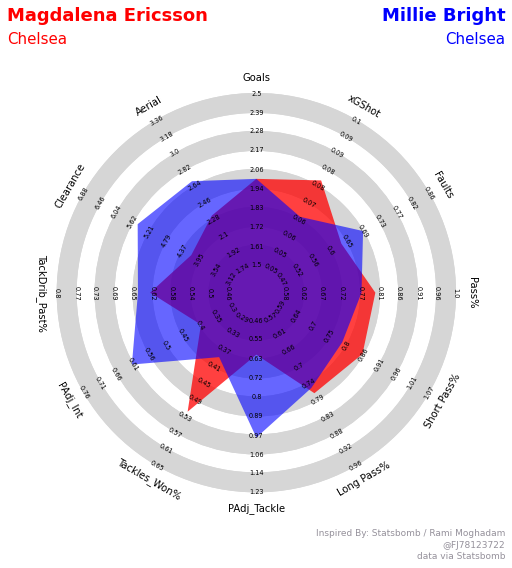

In [10]:
radar = Radar()

fig,ax = radar.plot_radar(ranges=ranges,params=["Goals","xGShot","Faults","Pass%","Short Pass%","Long Pass%","PAdj_Tackle","Tackles_Won%","PAdj_Int","TackDrib_Past%","Clearance","Aerial"]
,values=values,
                         radar_color=['red','blue'],
                         alphas=[.75,.6],title=title,endnote=endnote,
                         compare=True)
